# Chap02 End-to-End Machine Learning Project

Your task is to predict median house values in Californian districts, given a number of features from these districts.

In [100]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
# sklearn later for use


In [101]:
# Load the data
housing = pd.read_csv("../data/housing.csv")
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [102]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


total_bedrooms      20433 non-null  float64， 207 districts are missing this feature.

 ocean_proximity     20640 non-null  object ，we can research this feature to find out how many categories there are.

In [103]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [104]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


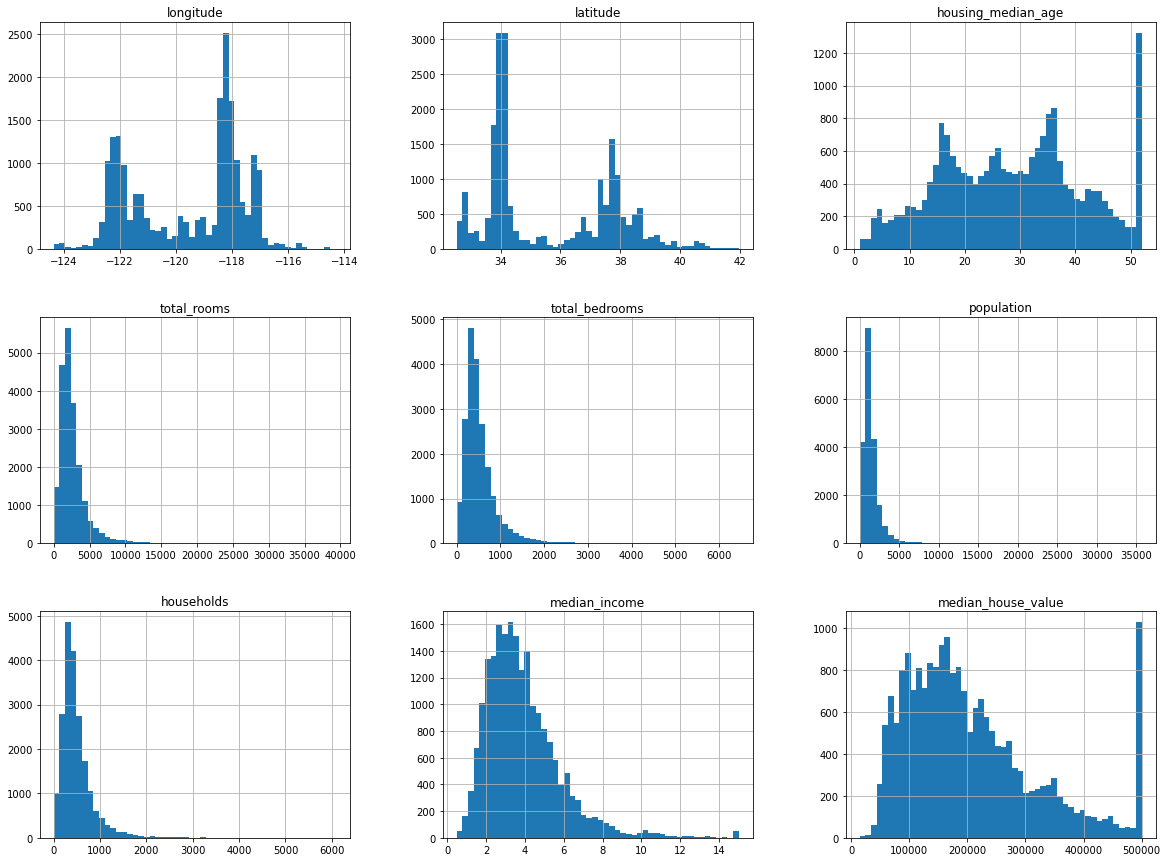

In [105]:
# pd histogram: a quick way to get a feel of the type of data 
# you are dealing with is to plot a histogram for each numerical attribute.
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [151]:
labels = list(housing.iloc[:,i].name for i in range(0,9))

In [143]:
# # Xs = [] is not suggested
# Xs = []
# for i in range(0,9):
#     x = housing.iloc[:,i]
#     Xs.append(x)
#     labels = list(housing.iloc[:,i].name)

In [144]:
len(housing.columns[:-1])

9

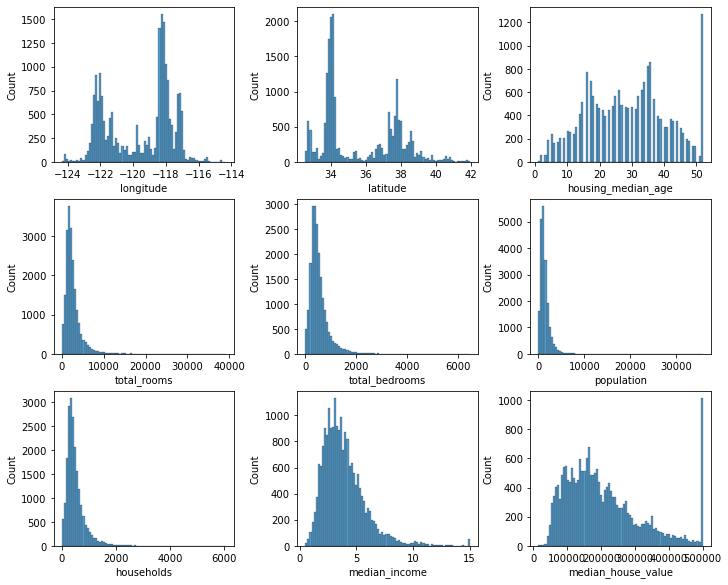

In [160]:
_, axes = plt.subplots(3, 3, figsize=(10, 8), constrained_layout=True)

for ax, col in zip(axes.flatten(), housing.columns[:-1]):
    sns.histplot(data=housing, x=col, bins=80, ax=ax)
    # plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

**There** are a few things you might notice in these histograms:

  1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the **data has been scaled and capped at 15** (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.


  2. **The housing median age and the median house value were also capped**. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit.You need to check with your client team (the team that will use your system’s out‐put) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:
        
       a. Collect proper labels for the districts whose labels were capped.

      b. **Remove those districts from the training set** (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).


  3. These attributes have very different scales. 
        
  4. Finally, **many histograms are tail-heavy:** they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distribution

### Create a Test Set

In [164]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [166]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2,random_state=42)


In [167]:

test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


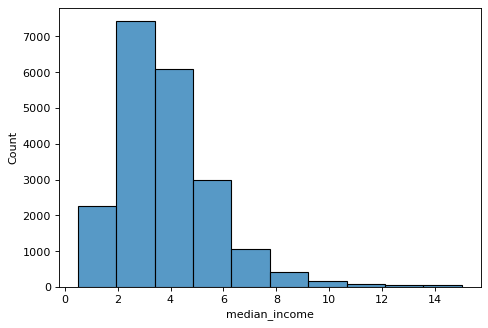

In [175]:
_, ax = plt.subplots(figsize=(6, 4), dpi=80,constrained_layout=True)

sns.histplot(data=housing, x='median_income', bins=10, ax=ax)
plt.show()